In [1]:
import numpy
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH = 'Datasets/trainYX.csv'
TEST_PATH = 'Datasets/testX.csv'

In [3]:
df = pd.read_csv(TRAIN_PATH)

df.head().iloc[:, :5]

,id,y,1,2,3
0,0,3,227,233,237
1,1,8,232,250,252
2,2,3,223,223,237
3,3,8,180,215,228
4,4,8,193,202,214


# Взглянем на изображения

In [4]:
count = 9
width = 32
# images = df.iloc[:, 2:].values[:count]
images = df.iloc[:, 2:].values[:].copy()

def draw_images(images_bytes: np.ndarray,
                skip: int = 0,
                count: int = 6,
                width: int = 32,
                labels: list[str] = None) -> None:
    fig = plt.figure(figsize=(12, 12))

    for i in range(skip, skip + count):
        ax = plt.subplot(int(count ** 0.5), int(count ** 0.5), i + 1)
        
        ax.imshow(images_bytes[i].reshape(width, width).astype('float'), cmap='gray')

        if labels is not None:
            plt.title(labels[i], fontsize=25, fontweight='bold')    

        ax.axis('off')
        plt.xticks([]), plt.yticks([])

    # plt.tight_layout(pad=0)
    plt.show()

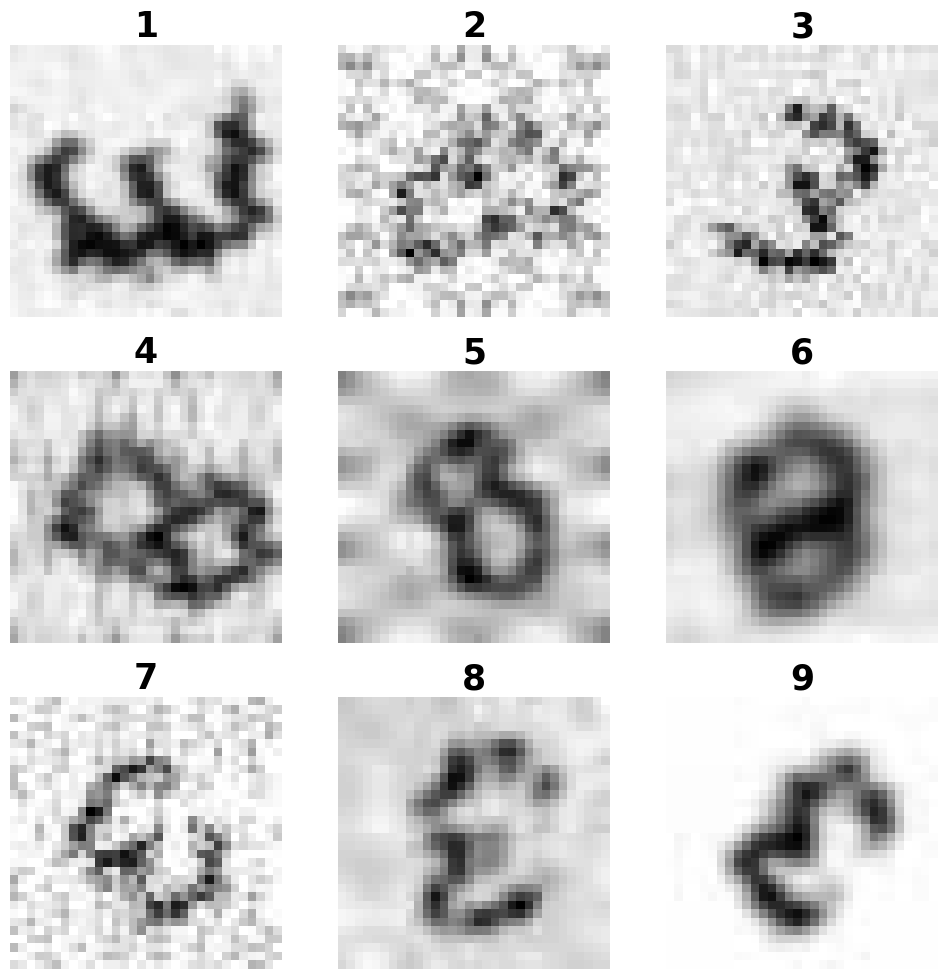

In [47]:
draw_images(images_bytes=images,
            count=count,
            width=width,
            labels=list(map(str, range(1, count + 1))))

In [ ]:
images = images.astype('float')
images /= 255.0

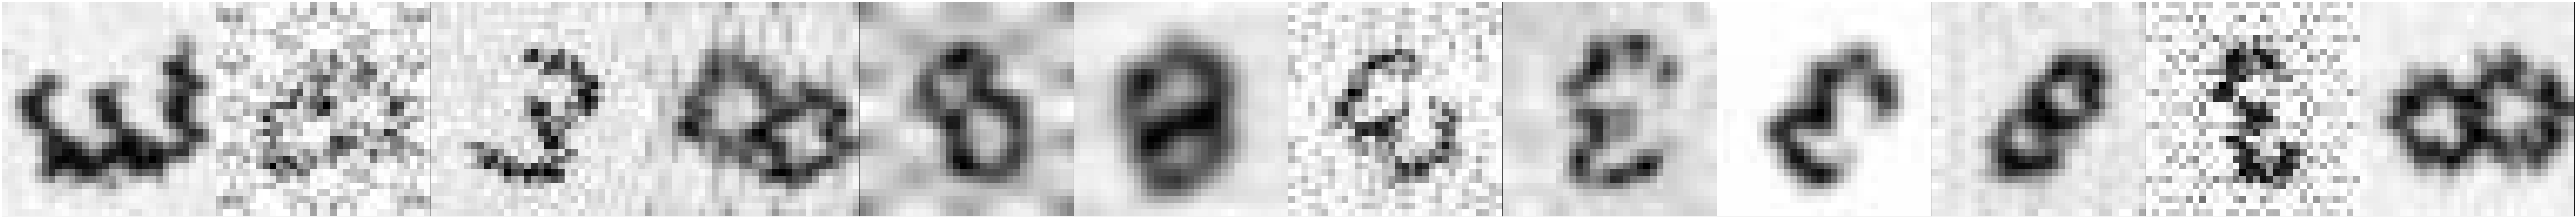

In [ ]:
draw_images(images_bytes=images,
            count=count,
            width=width)

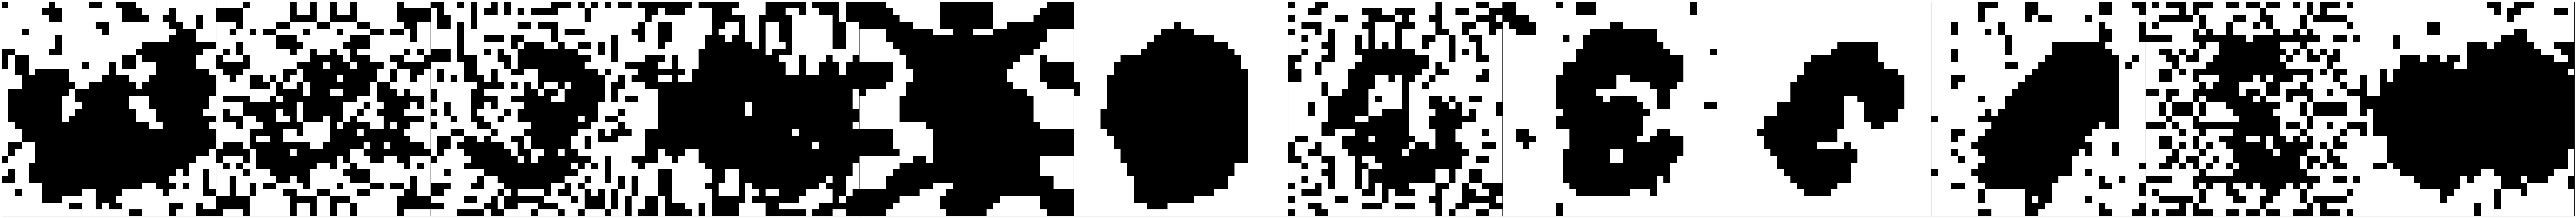

In [ ]:
def apply_max_pooling(images_bytes: np.ndarray):
    return np.where(images_bytes >= 0.90, 1.0, 0.0)

transformed_images = apply_max_pooling(images_bytes=images)

draw_images(images_bytes=transformed_images,
            count=count,
            width=width)

In [ ]:
images

array([[0.89019608, 0.91372549, 0.92941176, ..., 0.8745098 , 0.89019608,
        0.89803922],
       [0.90980392, 0.98039216, 0.98823529, ..., 0.96862745, 0.98431373,
        0.92941176],
       [0.8745098 , 0.8745098 , 0.92941176, ..., 0.85882353, 0.91372549,
        0.88627451],
       [0.70588235, 0.84313725, 0.89411765, ..., 0.91372549, 0.83921569,
        0.71372549],
       [0.75686275, 0.79215686, 0.83921569, ..., 0.83921569, 0.79607843,
        0.76078431],
       [0.90196078, 0.90588235, 0.90980392, ..., 0.94901961, 0.94901961,
        0.95294118]])

# Взглянем на изображения из тестовой выборки

In [5]:
test_df = pd.read_csv(TEST_PATH)

test_df.head()

,id,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,5000,242,242,242,241,240,239,238,237,235,...,233,233,234,238,238,235,234,236,235,231
1,5001,243,230,235,224,240,227,238,235,232,...,243,229,226,242,247,252,238,222,235,243
2,5002,247,250,254,253,251,248,249,250,245,...,244,247,248,248,247,245,243,243,245,247
3,5003,253,249,246,219,230,234,247,237,225,...,228,243,230,226,226,237,232,228,237,233
4,5004,241,238,233,229,229,231,234,237,239,...,241,235,234,231,228,228,230,234,238,239


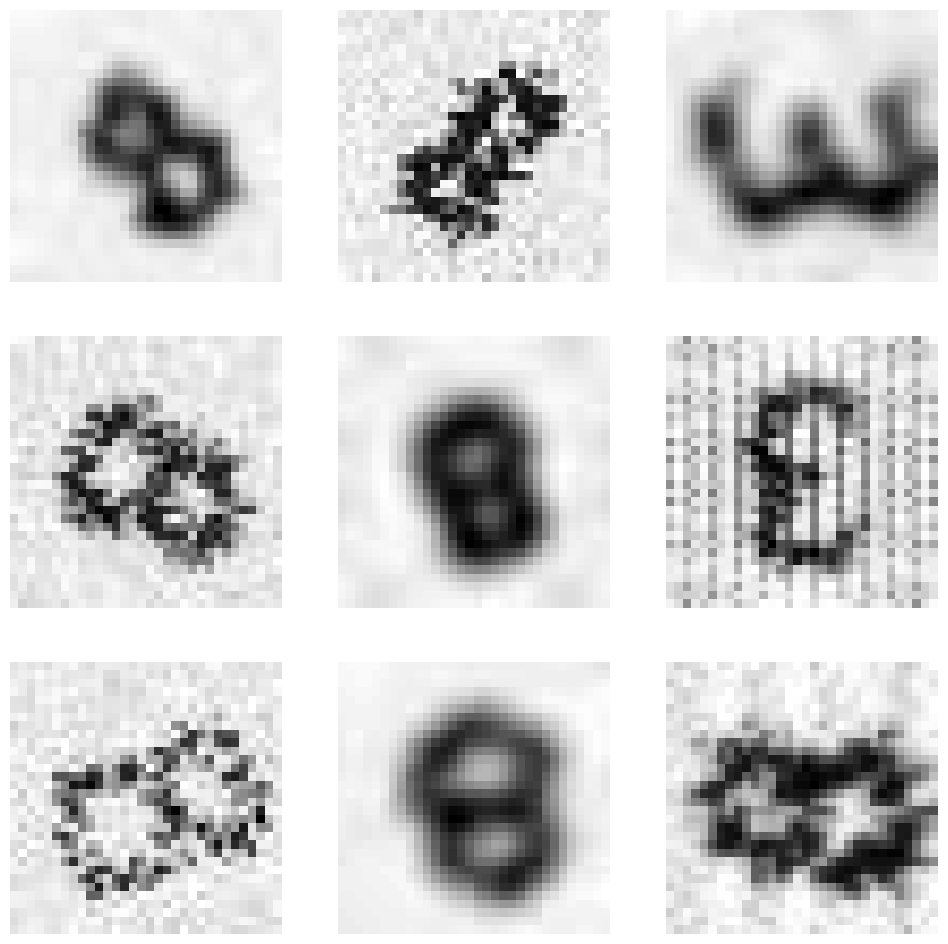

In [6]:
test_images = test_df.iloc[:, 1:].values[:].copy()

draw_images(images_bytes=test_images,
            count=count,
            width=width)

In [ ]:
test_images = test_images.astype('float')
test_images /= 255.0

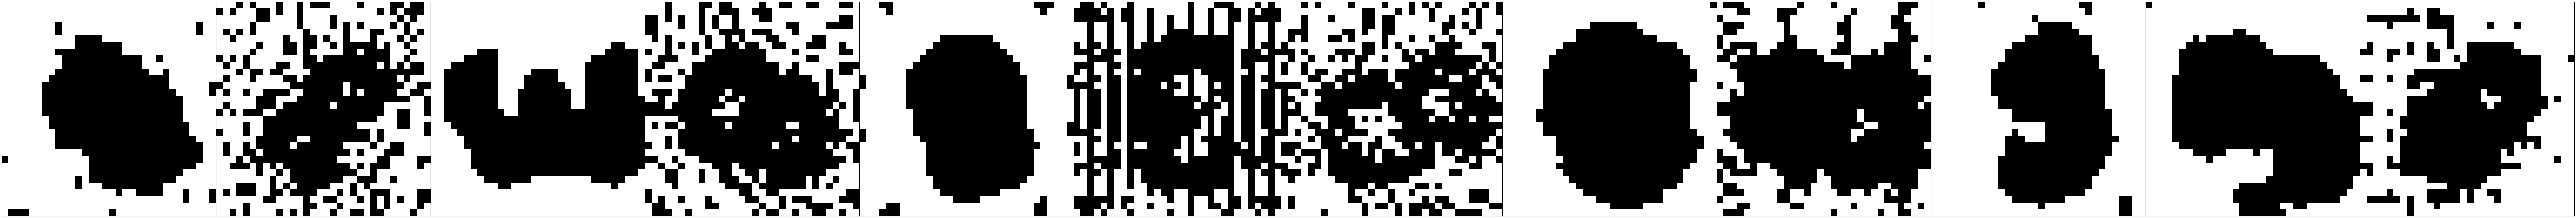

In [ ]:
transformed_test_images = apply_max_pooling(test_images)

draw_images(images_bytes=transformed_test_images,
            count=count,
            width=width)

## Попробуем использовать OpenCV

In [7]:
# first_image = images[1].reshape(width, width).astype(np.uint8)
# gray_image = cv.cvtColor(first_image, cv.COLOR_BGR2GRAY)


def transform_image(images_bytes: np.ndarray) -> np.ndarray:
    """
    Трансформирует изображение, используя блюр и метод Оцу
    """
    image = cv.normalize(images_bytes.astype(np.uint8), None, 0, 255, cv.NORM_MINMAX)
    image = cv.fastNlMeansDenoising(image, None, 10, 7, 21)
    kernel = np.ones((1, 1), np.uint8)
    erosion = cv.erode(image, kernel, iterations=1)
    blur = cv.GaussianBlur(erosion, (5, 5), 0)
    
    # blur = cv.medianBlur(images_bytes.reshape(width, width).astype(np.uint8), 3)
    # blur = cv.medianBlur(erosion, 3)
    
    sharp_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen = cv.filter2D(blur, -1, sharp_filter)
    
    k_value, thresh = cv.threshold(sharpen, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

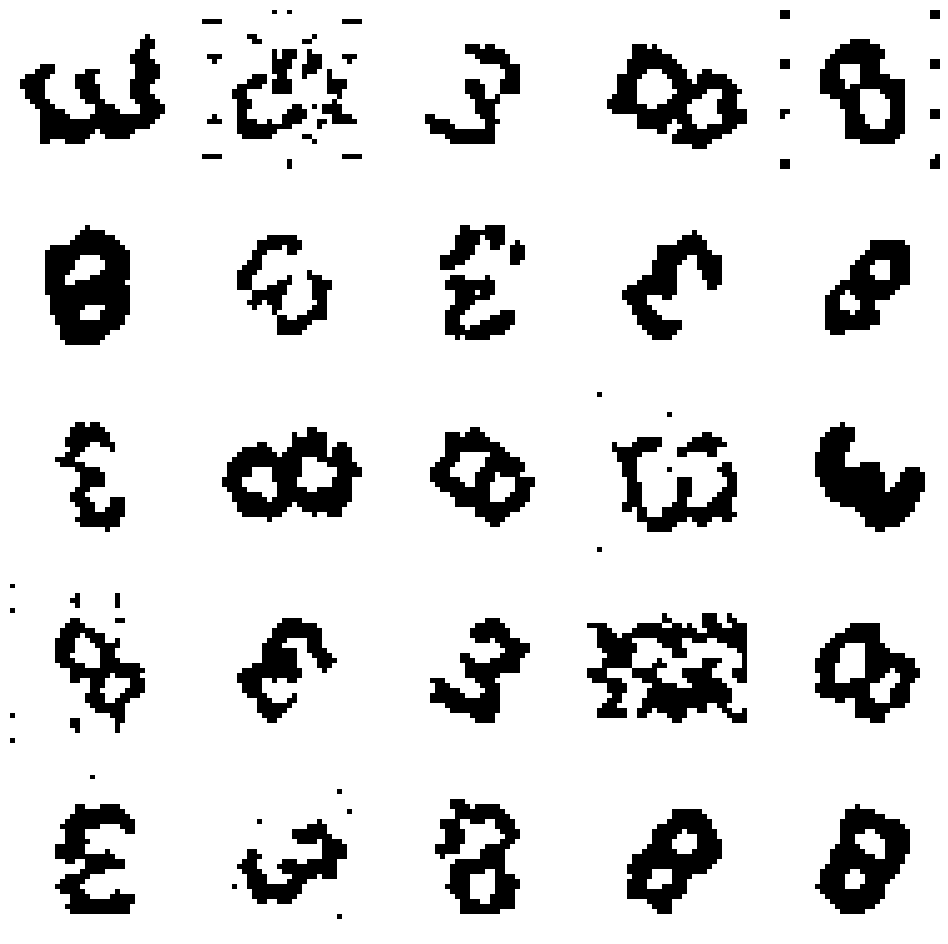

In [152]:
tilted_skip = 0
tilted_count = 25
imgs = df.iloc[:, 2:].values[:].copy()
X_tilted = imgs[tilted_skip:tilted_skip + tilted_count].reshape(-1, width, width)

for i in range(tilted_skip, tilted_skip + tilted_count):
    X_tilted[i] = transform_image(X_tilted[i])

draw_images(X_tilted, count=tilted_count, width=width)

# Модель на Keras

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
# from keras.utils.np_utils import to_categorical

In [9]:
X = images.copy()
X = X.reshape(X.shape[0], width, width)

for i in range(X.shape[0]):
  X[i] = transform_image(X[i])

# X = X.astype('float')
# X /= 255.0
X = X.reshape(X.shape[0], width, width, 1)

X.shape

(5000, 32, 32, 1)

In [ ]:
X[0]

array([[[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       ...,

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]]])

In [10]:
y = df.iloc[:, 1].values
# Apply binary transformation:
# 3 -> 1
# 8 -> 0
y = np.where(y == 3, 1, 0)

y[:5]

array([1, 0, 1, 0, 0])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [161]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       1

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
)  # randomly flip images


train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

In [164]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

early_stopping = EarlyStopping(
        monitor="val_loss", # metrics to monitor
        patience=15, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #
     )

reduce_on_plateau = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [165]:
# history = model.fit(train_gen,
#                     epochs = epochs,
#                     steps_per_epoch = train_steps,
#                     validation_data = test_gen,
#                     validation_steps = valid_steps,
#                     callbacks=[early_stopping, reduce_on_plateau, model_checkpoint])

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_on_plateau, model_checkpoint])

Epoch 1/100
25/25 [==============================] - 7s 226ms/step - loss: 0.4071 - accuracy: 0.8100 - val_loss: 8.6364 - val_accuracy: 0.5138 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 7s 274ms/step - loss: 0.1696 - accuracy: 0.9391 - val_loss: 0.9415 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 9s 355ms/step - loss: 0.1048 - accuracy: 0.9678 - val_loss: 0.3862 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 11s 465ms/step - loss: 0.0745 - accuracy: 0.9744 - val_loss: 0.2141 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 12s 504ms/step - loss: 0.0572 - accuracy: 0.9822 - val_loss: 0.1024 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9812
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 [==============================] - 18s 7

In [166]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

best_model = load_model('best_model.keras')

# Предсказываем вероятности принадлежности к классу
y_pred = best_model.predict(X_test)

# Конвертируем вероятности в классы
y_pred = np.where(y_pred >= 0.5, 1, 0).flatten()
y_true = y_test

print(accuracy_score(y_true, y_pred))

print(y_pred[:50])
print('--------')
print(y_true[:50])

32/32 [==============================] - 1s 20ms/step
0.981
[0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0
 1 0 1 1 1 1 1 0 1 1 0 0 1]
--------
[0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0
 1 0 1 1 1 1 1 0 1 1 0 0 1]


# Делаем предсказания на тестовом датасете

In [167]:
X_final = test_images.copy()
X_final = X_final.reshape(X_final.shape[0], width, width)

for i in range(X_final.shape[0]):
  X_final[i] = transform_image(X_final[i])

# X_final = X_final.astype('float')
# X_final /= 255.0
X_final = X_final.reshape(X_final.shape[0], width, width, 1)

X_final.shape

(5000, 32, 32, 1)

In [170]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

best_model = load_model('best_model.keras')

# Предсказываем вероятности принадлежности к классу
y_pred_final = best_model.predict(X_final)

# Конвертируем вероятности в классы
y_pred_final = np.where(y_pred_final >= 0.5, 1, 0).flatten()
y_pred_final = np.where(y_pred_final == 1, '3', '8')

final_df = pd.DataFrame({
    'id': range(5000, 5000 + X_final.shape[0]),
    'y': y_pred_final,
})

final_df.to_csv('submission.csv', index=False)

# draw_images(X_final, count=16, width=width, labels=y_pred_final, skip=50)

157/157 [==============================] - 3s 19ms/step


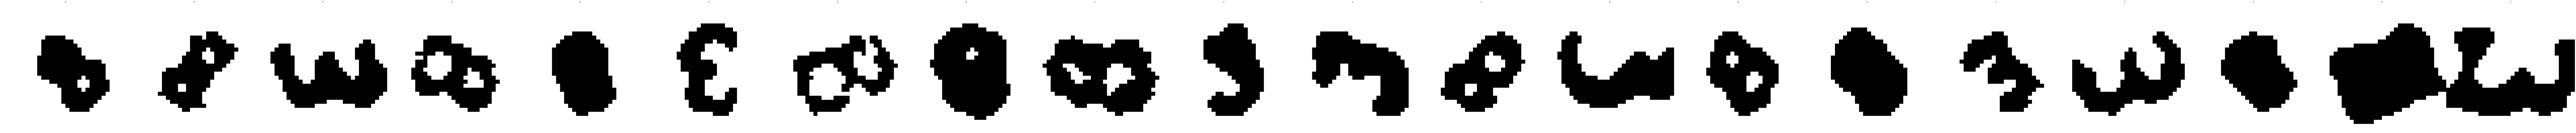

In [ ]:
image_labels = list(np.where(y_pred_final == 1, '3', '8'))
draw_images(images_bytes=X_final, count=20, width=width, labels=image_labels[:20])

# IDEAS
1. Gaussian blur / Median blur
2. Additional processing of images
3. CatBoost + other models stacking
4. Data Augmentation

возможно, стоит умножнать блюр на исходное изображение, чтобы избавиться от всего шума

In [ ]:
X_test

array([[[[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        ...,

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]]],


       [[[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [

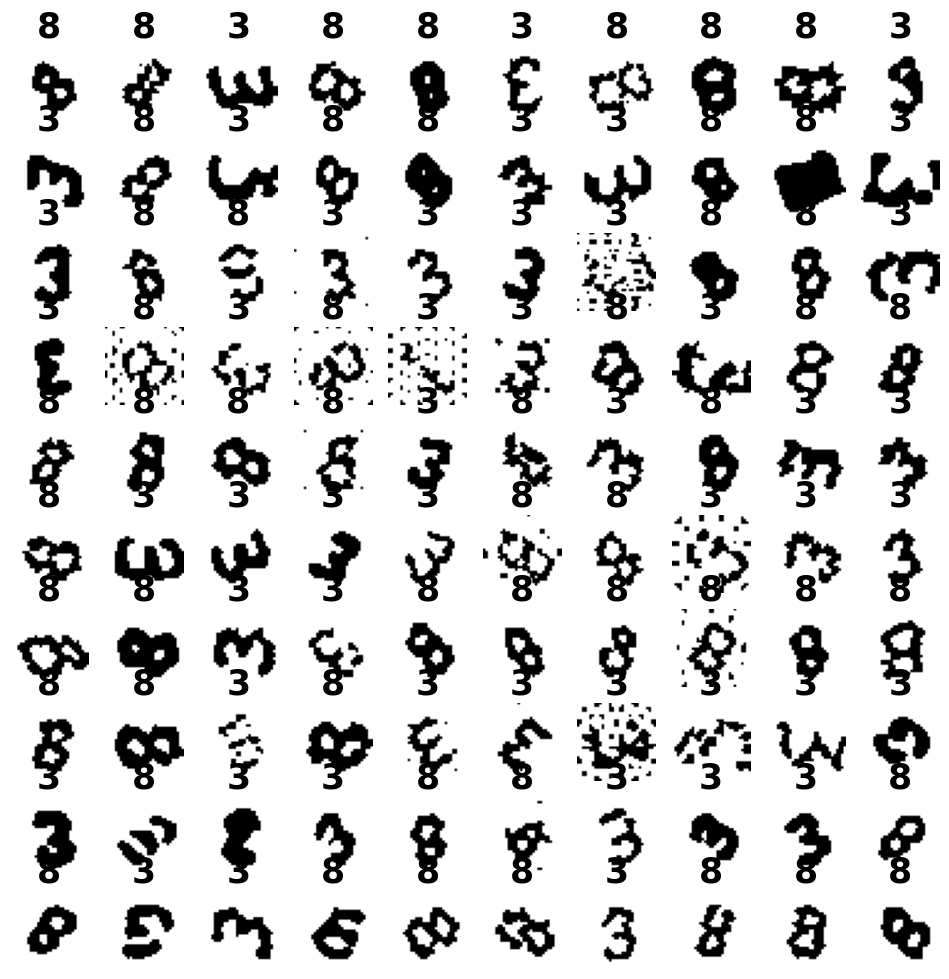

In [172]:
draw_images(X_final, count=100, width=width, labels=y_pred_final)

In [38]:
# Предобработка данных
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

n_components = 30

X_train_flat = X_train.reshape(X_train.shape[0], width * width)
# StandardScaler()
pipeline = make_pipeline(
                         # PCA(n_components=n_components),
                         MLPRegressor(early_stopping=True,
                                      n_iter_no_change=15,
                                      solver='adam',
                                      verbose=20,
                                      max_iter=2500))

In [39]:
pipeline.fit(X_train_flat, y_train)

Iteration 1, loss = 79428.73121913
Validation score: -148789.777792
Iteration 2, loss = 7975.53325875
Validation score: -14589.780038
Iteration 3, loss = 1784.48678749
Validation score: -12894.981827
Iteration 4, loss = 1113.96063319
Validation score: -8373.930261
Iteration 5, loss = 934.48248327
Validation score: -7638.360949
Iteration 6, loss = 850.20193536
Validation score: -6970.077473
Iteration 7, loss = 775.57911046
Validation score: -6550.296197
Iteration 8, loss = 706.87136793
Validation score: -6028.671468
Iteration 9, loss = 653.94455195
Validation score: -5918.684661
Iteration 10, loss = 611.56355226
Validation score: -5449.852618
Iteration 11, loss = 575.24025474
Validation score: -4977.506443
Iteration 12, loss = 533.49543107
Validation score: -4823.600854
Iteration 13, loss = 502.07331134
Validation score: -4468.612381
Iteration 14, loss = 476.83715736
Validation score: -4257.108311
Iteration 15, loss = 452.91283934
Validation score: -4074.062647
Iteration 16, loss = 437.

Pipeline(steps=[('mlpregressor',
                 MLPRegressor(early_stopping=True, max_iter=2500,
                              n_iter_no_change=15, verbose=20))])

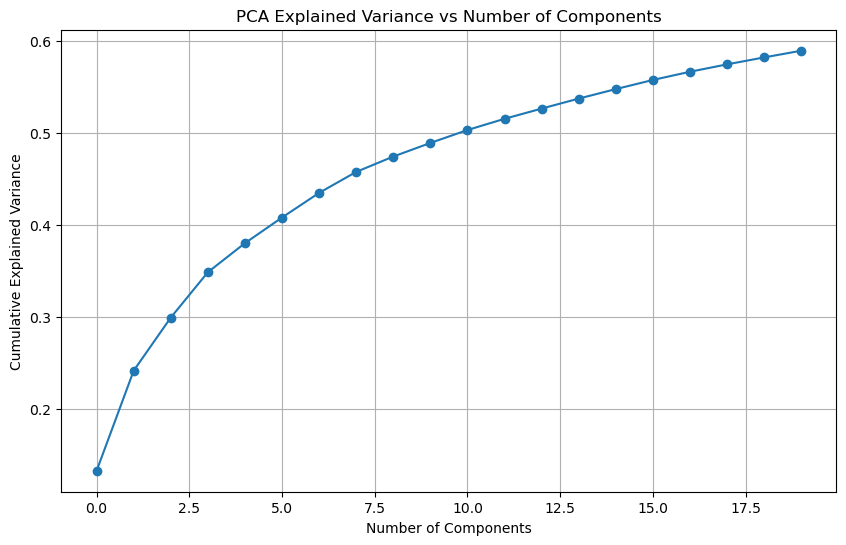

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Предположим, у вас есть массив изображений X_train с формой (num_samples, height, width, channels)

# print(X_train.shape)

# Преобразуем изображения в двумерный формат для PCA
num_samples, height, width, channels = X_train.shape
X_train_flat = X_train.reshape(num_samples, height * width * channels)

# Применение PCA
pca = PCA(n_components=20)
pca.fit(X_train_flat)

# Объясненная дисперсия для различных значений n_components
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Построение графика explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance vs Number of Components')
plt.grid(True)
plt.show()